# Gamma model integration test (for semi-Markov models)

Try Gamma Poisson Model inference on data generated from that model. Should recover synthetic data.

## If you want overdispersion in the model:

Set the following to `True`:

In [1]:
overdisp = True

# Generate Test Data

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import gamma_model as gp
from helpers import *
%matplotlib inline
sns.set_style('darkgrid')
np.random.seed(11739)

## Define model parameters

In [3]:
U = 100  # units
T = 10000  # time points/frames
D = 100  # durations
Kdata = 3  # number of latent states
dt = 1/30  # seconds per frame
Mz = 2  # number of states for each latent

## Duration distribution

In [4]:
# want 0 more prevalent than 1
mm = np.empty((Mz, Kdata))
mm[0] = 50 * np.random.rand(Kdata)
mm[1] = 15 * np.random.rand(Kdata)

ss = np.empty((Mz, Kdata))
ss[0] = 1 * np.random.rand(Kdata)
ss[1] = 2 * np.random.rand(Kdata)

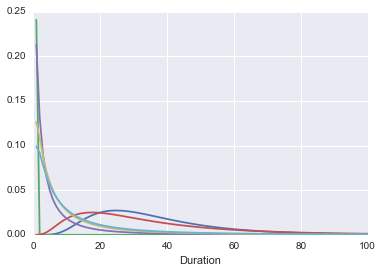

In [5]:
dvec = np.arange(1, D + 1)
for (m, s) in zip(mm.ravel(), ss.ravel()):
    plt.plot(dvec, stats.lognorm.pdf(dvec, scale=m, s=s))
plt.xlabel('Duration');

## Generate Markov chains

In [6]:
# make transition matrix
A = np.array([[0, 1.0], [1.0, 0]])
pi = np.array([0.5, 0.5])  # start all states "off"

In [7]:
chain = np.empty((T, Kdata))

# pick pars for duration distribution
mm = 10 * np.random.rand(2, Kdata) # mean
ss = 3 * np.random.rand(2, Kdata) # standard deviation

# initialize
for k in xrange(Kdata):
    t = 0
    while t < T:
        if t == 0:
            pp = pi[1]
        else:
            pp = A[1, chain[t - 1, k]]

        # pick a new state
        z = stats.bernoulli.rvs(pp, size=1)

        # pick a duration
        d = stats.lognorm.rvs(scale=mm[z, k], s=ss[z, k], size=1)[0].astype('int')
        d = np.min([d, T - d])
        d = np.max([d, 1])

        # fill in the next d steps of the chain
        chain[t:(t+d), k] = z
        t += d


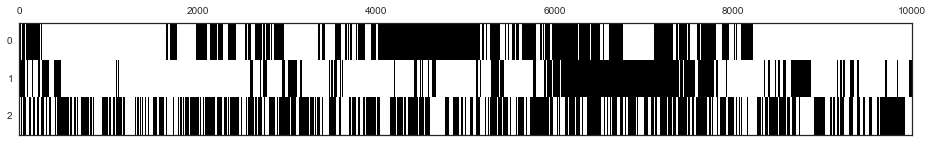

In [8]:
matshow(chain.T);

## Baseline distributions

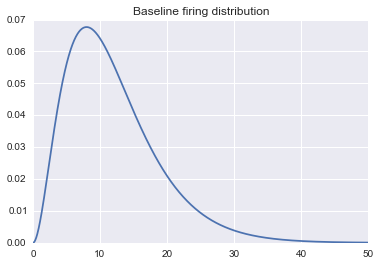

In [9]:
bl_shape = 3
bl_scale = 4
# baselines should follow a different distribution
bl = stats.gamma.rvs(a=bl_shape, scale=bl_scale, size=U) 

xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=bl_shape, scale=bl_scale))
plt.title('Baseline firing distribution');

## Firing rate effect distributions

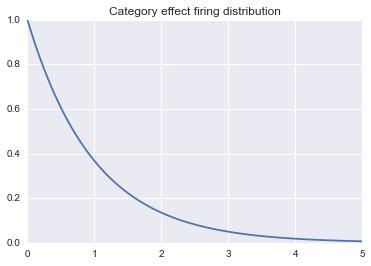

In [10]:
# firing rates
fr_shape = 1
fr_rate = 1
lam = stats.gamma.rvs(a=fr_shape, scale=1/fr_rate, size=(Kdata, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=fr_shape, scale=1/fr_rate))
plt.title('Category effect firing distribution');

## Overdispersion

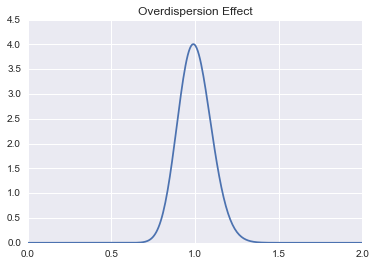

In [11]:
if overdisp:
    xx = np.linspace(0, 2, 300)
    th_scale = 100
    plt.plot(xx, stats.gamma.pdf(xx, a=th_scale, scale=1./th_scale))
    plt.title('Overdispersion Effect');

## External regressors

In [12]:
# just as above, make a set of Markov-esque regressors

# number of regressors
R = 3  

# "transition matrix" -- want regressors to have some temporal coherence
AX = np.array([[0.98, 0.05], [0.02, 0.95]])

In [13]:
Xchain = np.empty((T, R))

Xchain[0, :] = 0  # start second category off
for t in xrange(1, T):
    for k in xrange(0, R):
        Xchain[t, k] = stats.bernoulli.rvs(AX[1, Xchain[t - 1, k]])

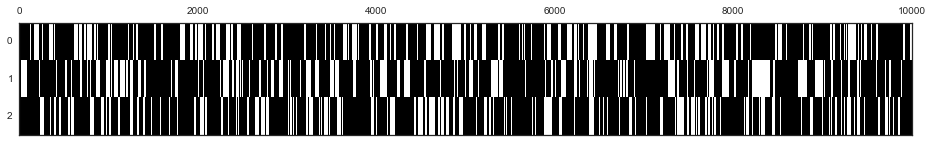

In [14]:
matshow(Xchain.T);

In [15]:
Xf = pd.DataFrame(Xchain, columns=map(lambda x: 'X' + str(x), xrange(R)))
Xf.index.name = 'frame'
Xf = Xf.reset_index()

In [16]:
Xf.head()

,frame,X0,X1,X2
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0


In [17]:
# make firing rate effects for each (regressor, unit)
Xfr_shape = 45
Xfr_scale = 1. / 45
Xlam = stats.gamma.rvs(a=Xfr_shape, scale=Xfr_scale, size=(R, U))

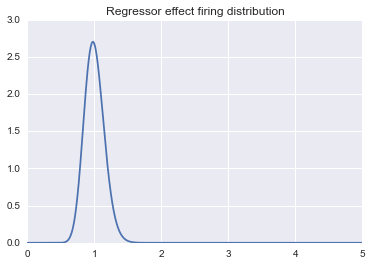

In [18]:
xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.gamma.pdf(xx, a=Xfr_shape, scale=Xfr_scale))
plt.title('Regressor effect firing distribution');

## Calculate firing rates

Let $\lambda_0$ be the baseline, $\lambda_k$ the firing rate for latent category $i$ with binary indicator variable $z_{tk}$ and $\nu_{r}$ be the firing rate effect for external regressor $r$ with value $x_{tr}$. Let $\theta_{t}$ be an overdispersion factor for each time bin. The firing rate of unit $u$ at time $t$ is then given by

$$
\mu_{tu} = \lambda_{0u} \theta_{tu} \prod_k  \lambda_{ku}^{z_{tk}}
\prod_r \nu_{ru}^{x_{tr}}
$$

In [19]:
# calculate rate within each time bin
fr = bl * np.exp(chain.dot(np.log(lam)) + Xchain.dot(np.log(Xlam))) * dt
fr += 1e-5  # in case we get exactly 0

# add overdispersion
if overdisp:
    theta = stats.gamma.rvs(a=10, scale=1./10, size=fr.shape)
    fr *= theta

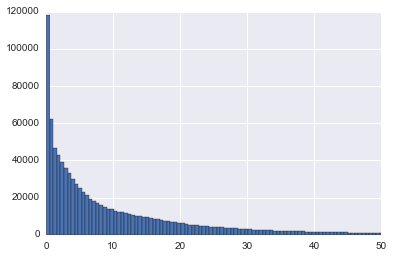

In [20]:
# get a crude sense of population firing
plt.hist(fr.ravel() / dt, bins=1000);
plt.xlim(0, 50);

## Look at generated data

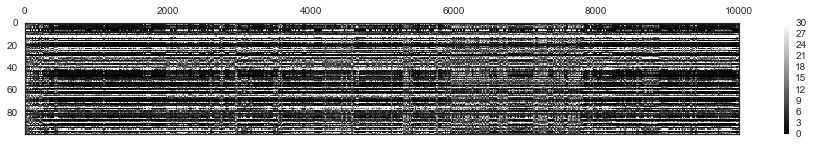

In [21]:
matshow(fr.T / dt, vmax=30);
plt.colorbar();

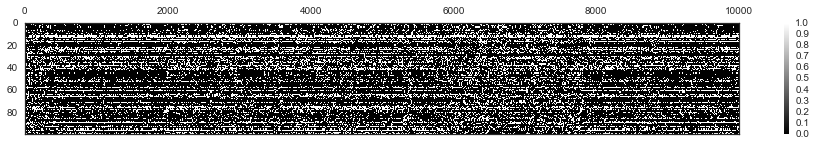

In [22]:
# draw from Poisson
N = stats.poisson.rvs(fr)
matshow(N.T, vmax=1);
plt.colorbar();

In [23]:
# make count frame
df = pd.DataFrame(N)
df.index.name = 'frame'
df = df.reset_index()
df = pd.melt(df, id_vars='frame')
df.columns = ['frame', 'unit', 'count']
df['movie'] = 1

df = df.merge(Xf)

df.head()

,frame,unit,count,movie,X0,X1,X2
0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,0
2,0,2,0,1,0,0,0
3,0,3,0,1,0,0,0
4,0,4,0,1,0,0,0


Finally, convert (frame, movie) pairs to unique times:

In [24]:
df = frames_to_times(df)
M = df.shape[0]
df.head()

,unit,count,X0,X1,X2,time
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0


# Set up Priors

## Priors on baseline:

We will use a hierarchical model for both baselines and firing rate effects, with  
$$
\lambda_{u} \sim \mathrm{Ga}(c, c\theta) \\
c \sim \text{Ga}(s, r) \\
\theta \sim \text{Ga}(t, w) \\
\mathbb{E}[\lambda_{u}] = \frac{1}{\theta} \\
\mathrm{var}[\lambda_{u}] = \frac{1}{c \theta^2}
$$
In other words, we can think of $\frac{1}{\theta}$ as a *mean parameter* and $\frac{1}{c}$ as a *variance parameter*.

We want the baseline rates to have a fairly reasonable prior and the effect rates to have a very sparse prior, closely concentrated around 1.

The following function will help us get a sense of the distribution on $\lambda$ induced by our hyperparameter choices.

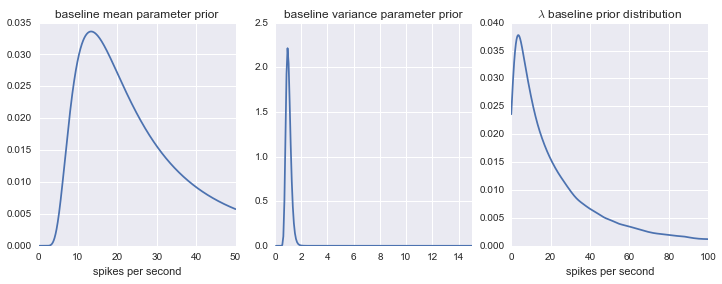

In [25]:
bl_mean_shape = 2.
bl_mean_rate = 40 * dt  # actual parameter should be per-bin rate
bl_shape_shape = 30.
bl_shape_rate = 30.

baseline_dict = ({
            'prior_shape_shape': bl_shape_shape, 
            'prior_shape_rate': bl_shape_rate, 
            'prior_mean_shape': bl_mean_shape, 
            'prior_mean_rate': bl_mean_rate})

# make some plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=bl_mean_shape, scale=bl_mean_rate / dt))
plt.title('baseline mean parameter prior');
plt.xlabel('spikes per second')

plt.subplot(1, 3, 2)
xx = np.linspace(0, 80, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=bl_shape_shape, scale=bl_shape_rate))
plt.title('baseline variance parameter prior');
plt.xlim(0, 15)

plt.subplot(1, 3, 3)
samples = gamma_from_hypers([bl_mean_shape, bl_mean_rate], 
                            [bl_shape_shape, bl_shape_rate], 1e5)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 150))
plt.title(r'$\lambda$ baseline prior distribution')
plt.xlim(0, 100);
plt.xlabel('spikes per second');



## Priors on latent firing rate effects:

In [26]:
# set number of categories to fit
K = 5

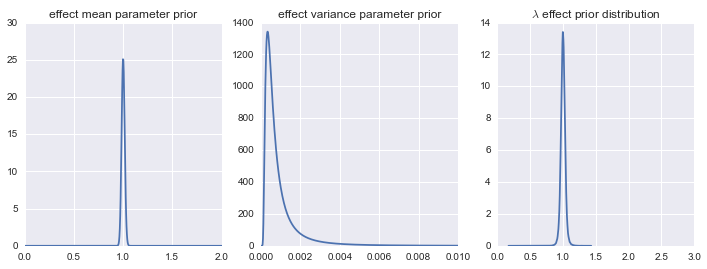

In [27]:
fr_shape_shape = 2. * np.ones((K,))
fr_shape_rate = 1e-3 * np.ones((K,))
fr_mean_shape = 0.4 * T * np.ones((K,))
fr_mean_rate = 0.4 * T * np.ones((K,))

fr_latent_dict = ({
            'prior_shape_shape': fr_shape_shape, 
            'prior_shape_rate': fr_shape_rate, 
            'prior_mean_shape': fr_mean_shape, 
            'prior_mean_rate': fr_mean_rate})

# make some plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=fr_mean_shape[0], scale=fr_mean_rate[0]))
plt.title('effect mean parameter prior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 0.01, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=fr_shape_shape[0], scale=fr_shape_rate[0]))
plt.title('effect variance parameter prior');

plt.subplot(1, 3, 3)
samples = gamma_from_hypers([fr_mean_shape[0], fr_mean_rate[0]], 
                            [fr_shape_shape[0], fr_shape_rate[0]], 1e5)
sns.kdeplot(samples, gridsize=5000, clip=(0, 5))
plt.title(r'$\lambda$ effect prior distribution')
plt.xlim(0, 3);

## Priors on semi-Markov model

### $A$, $\pi$

In [28]:
###### A ###############
A_off = 10.
A_on = 1.
Avec = np.r_[A_off, A_on].reshape(2, 1, 1)
A_prior = np.tile(Avec, (1, 2, K))

###### pi ###############
pi_off = 15.
pi_on = 1.
pi_prior = np.tile(np.r_[pi_off, pi_on].reshape(2, 1), (1, K))

latent_dict = {'A_prior': A_prior, 'pi_prior': pi_prior}

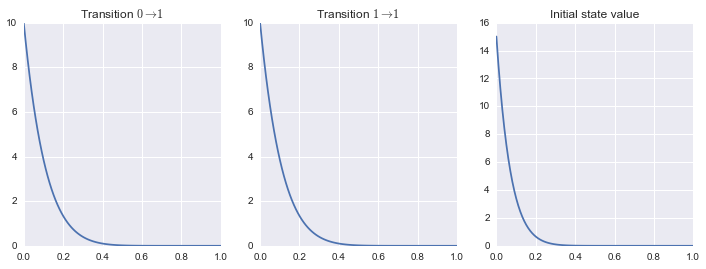

In [29]:
xx = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 0, 0], A_prior[0, 0, 0]))
plt.title(r'Transition $0 \rightarrow 1$');

plt.subplot(1, 3, 2)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 1, 0], A_prior[0, 1, 0]))
plt.title(r'Transition $1 \rightarrow 1$');

plt.subplot(1, 3, 3)
plt.plot(xx, stats.beta.pdf(xx, pi_prior[1, 0], pi_prior[0, 0]))
plt.title('Initial state value');


### Duration

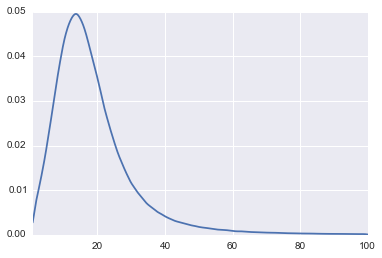

In [30]:
d_hypers = (3., 40., 2., 20.)
drng = (min(dvec), max(dvec))
samples = lognormal_from_hypers(*d_hypers, N=1e6)
sns.kdeplot(samples, gridsize=1000, clip=drng);
plt.xlim(*drng);

In [31]:
d_pars = ({'d_prior_mean': d_hypers[0] * np.ones((Mz, K)), 
          'd_prior_scaling': d_hypers[1] * np.ones((Mz, K)),
          'd_prior_shape': d_hypers[2] * np.ones((Mz, K)),
          'd_prior_rate': d_hypers[3] * np.ones((Mz, K))})

latent_dict.update(d_pars)

## Priors on $\theta$ (overdispersion)

In [32]:
od_shape = 6.
od_rate = 5.
od_dict = {'prior_shape': od_shape * np.ones((M,)), 'prior_rate': od_rate * np.ones((M,))}

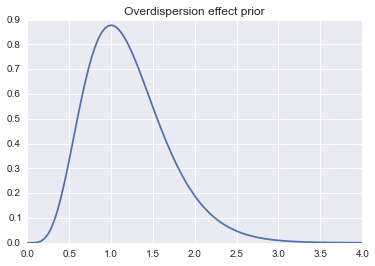

In [33]:
xx = np.linspace(0, 4, 100)
plt.plot(xx, stats.gamma.pdf(xx, a=od_shape, scale=1./od_rate))
plt.title('Overdispersion effect prior');

## Priors on $\upsilon$ (regression coefficients)

In [34]:
ups_shape = 11.
ups_rate = 10.
reg_shape = ups_shape * np.ones((U, R))  # shape
reg_rate = ups_rate * np.ones((U, R))  # rate

reg_dict = {'prior_shape': reg_shape, 'prior_rate': reg_rate}

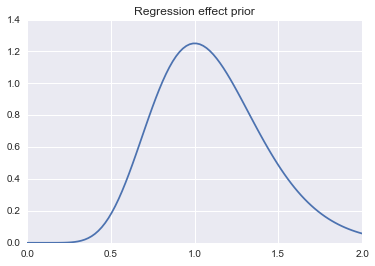

In [35]:
xx = np.linspace(0, 2, 100)
plt.plot(xx, stats.gamma.pdf(xx, a=ups_shape, scale=1./ups_rate))
plt.title('Regression effect prior');

# Initial guesses for posterior parameters

In [36]:
# baseline posteriors
bld = ({'post_shape_shape': bl_shape_shape, 'post_shape_rate': bl_shape_rate, 
        'post_mean_shape': bl_mean_shape, 'post_mean_rate': bl_mean_rate,
        'post_child_shape': np.ones((U,)), 'post_child_rate': np.ones((U,))})
baseline_dict.update(bld)

In [37]:
# firing rate effects for latents
frd = ({'post_shape_shape': fr_shape_shape, 'post_shape_rate': fr_shape_rate, 
        'post_mean_shape': fr_mean_shape, 'post_mean_rate': fr_mean_rate,
        'post_child_shape': np.ones((U, K)), 'post_child_rate': np.ones((U, K))})
fr_latent_dict.update(frd)

In [38]:
# latent states

# E[z]
# initialize pretty much at random (10% 1's)
rand_frac = 0.1
xi_mat = (rand_frac >= np.random.rand(T, K))
xi_mat = xi_mat.astype('float')
z_prior = np.dstack([1 - xi_mat, xi_mat]).transpose((2, 0, 1))

# E[zz]
Xi_mat = rand_frac >= np.random.rand(2, 2, T - 1, K)
Xi_mat = Xi_mat.astype('float')

ld = ({'A_post': A_prior, 'pi_post': pi_prior, 'z_init': z_prior,
       'zz_init': Xi_mat, 'logZ_init': np.zeros((K,))})
latent_dict.update(ld)

In [39]:
# durations
d_inits = (3., 100., 50., 20.)

d_post_pars = ({'d_post_mean': d_inits[0] * np.ones((Mz, K)), 
                'd_post_scaling': d_inits[1] * np.ones((Mz, K)),
                'd_post_shape': d_inits[2] * np.ones((Mz, K)),
                'd_post_rate': d_inits[3] * np.ones((Mz, K))})
latent_dict.update(d_post_pars)

In [40]:
# firing rate regressors
# since we know exact update for a_mat, use that
nn = df['count']
uu = df['unit']
NX = nn[:, np.newaxis] * df.iloc[:, -R:]
a_mat = NX.groupby(uu).sum().values
b_mat = a_mat.copy()

reg_dict.update({'post_shape': a_mat, 'post_rate': b_mat})

In [41]:
# overdispersion
od_dict.update({'post_shape': np.ones((M,)), 'post_rate': np.ones((M,))})

# Do inference with random restarts:

In [42]:
numstarts = 1

In [43]:
fitobjs = []
Lvals = []
for idx in xrange(numstarts):
    gpm = gp.GammaModel(df, K, D)
    gpm.initialize_baseline(**jitter_inits(baseline_dict, 0.25))
    gpm.initialize_fr_latents(**jitter_inits(fr_latent_dict, 0.25))
    gpm.initialize_latents(**jitter_inits(latent_dict, 0.05))
    gpm.initialize_fr_regressors(**jitter_inits(reg_dict, 0.05))
    if overdisp:
        gpm.initialize_overdispersion(**jitter_inits(od_dict, 0.25))
    gpm.finalize()
    
    print "Start {} -----------------------".format(idx)
    %time gpm.do_inference(tol=1e-4, verbosity=2)
    print "Final L = {}".format(gpm.L())
    Lvals.append(gpm.L())
    fitobjs.append(gpm)

Start 0 -----------------------
Iteration 0: L = -5276039.5442
delta = 1
         updated baselines: L = -4570611.34164
chain 0: updated firing rate effects: L = -4258619.77415
chain 1: updated firing rate effects: L = -3967990.19213
chain 2: updated firing rate effects: L = -3734054.01542
chain 3: updated firing rate effects: L = -3461983.07844
chain 4: updated firing rate effects: L = -3190991.8349
         updated regressor effects: L = -3182068.69063
         updated overdispersion effects: L = -670866.14872
> /Users/jmxp/code/spiketopics/gamma_model.py(562)iterate()
-> self.nodes['HMM'].update(k, logpsi)
(Pdb) s
--Call--
> /Users/jmxp/code/spiketopics/nodes/HMM.py(175)update()
-> def update(self, idx, log_evidence):
(Pdb) n
> /Users/jmxp/code/spiketopics/nodes/HMM.py(187)update()
-> zz = self.nodes['z'].zz[..., idx]
(Pdb) n
> /Users/jmxp/code/spiketopics/nodes/HMM.py(188)update()
-> zz_bar = np.sum(zz, axis=2)  # sum over time
(Pdb) n
> /Users/jmxp/code/spiketopics/nodes/HMM.py(18

BdbQuit: 

In [ ]:
# pick out best fit
bestind = np.argmax(Lvals)
gpm = fitobjs[bestind]
del fitobjs  # to save memory

# Check results

## Do we correctly recover $z$?

Zoom in on a small part of the time series:

In [ ]:
Trng = (500, 1000)
matshow(chain.T[:, slice(*Trng)], vmin=0, vmax=1);
xi = gpm.nodes['HMM'].nodes['z'].z[1]
matshow(xi.T[:, slice(*Trng)], vmin=0, vmax=1);

What about the whole time series?

In [ ]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi.T, vmin=0, vmax=1);

In [ ]:
matshow(chain.T);
plt.title('Actual states')
matshow(xi.T, vmin=0, vmax=1);
plt.title('Inferred states')
matshow(fr.T / dt, vmax=30);
plt.title('Actual firing rate')
matshow(N.T, vmin=0, vmax=1);
plt.title('Spike rastergram');

In [ ]:
match = (chain.T.dot(xi) + (1 - chain.T).dot(1 - xi)) / T
mismatch = (chain.T.dot(1 - xi) + (1 - chain.T).dot(xi)) / T
overlap = np.maximum(match, mismatch)

## Calculate overlap between actual and inferred latents

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [ ]:
matshow(overlap, vmin=0, vmax=1)
plt.colorbar();
plt.xlabel('Inferred categories');
plt.ylabel('Actual categories');

In [ ]:
print overlap

## Duration distributions

In [ ]:
dnode = gpm.nodes['HMM'].nodes['d']

## Diagnostics for gamma-distributed variables

Let's look at what we get for $\lambda$, $\theta$, and $\upsilon$:

### Baselines

In [ ]:
plt.figure(figsize=(12, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title(r'$\lambda$ baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

In [ ]:
plt.figure(figsize=(12, 4))

inferred_means = gpm.nodes['baseline'].expected_x() / dt

plt.subplot(1, 2, 1)
plt.hist(bl, bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Baseline firing rates');

plt.subplot(1, 2, 2)
plt.scatter(bl, inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('baseline rates');

### $\lambda$ terms (latents for each unit)

In [ ]:
plt.figure(figsize=(12, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']
th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]))
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]))
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10))
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 2);

In [ ]:
plt.hist(lam.ravel(), bins=50, normed=True, alpha=0.25)
inferred_effects = gpm.nodes['fr_latents'].expected_x().ravel()
plt.hist(inferred_effects, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Firing rate effects');

### $\theta$ terms (overdispersion)

In [ ]:
if overdisp:
    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(theta.ravel(), bins=500, normed=True, alpha=0.25)
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.legend(['actual', 'inferred']);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

In [ ]:
plt.scatter(theta.ravel(), inferred_means, alpha=0.01);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('overdispersion');

### $\upsilon$ terms (regressors)

In [ ]:
inferred_means = gpm.nodes['fr_regressors'].expected_x().ravel()
plt.hist(Xlam.ravel(), bins=50, normed=True, alpha=0.25)
plt.hist(inferred_map, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Regression effects');
plt.ylim(0, 5);
plt.xlim(0, 2);

In [ ]:
plt.scatter(Xlam.T.ravel(), inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('regression weights');